In [1]:
import json
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm, tqdm_notebook

In [2]:
tqdm_notebook().pandas()

pd.set_option('precision',2)

sns.set_style("darkgrid")

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [3]:
data_folder = Path("output_files/PKP/")
input_file = Path("input_files/PKP_20171220.csv")

In [53]:
data_folder = Path("output_files/new_test/")
input_file = Path("input_files/test.csv")

In [4]:
df_input = pd.read_csv(input_file,
                       index_col="doi",
                       parse_dates=["date"]).drop_duplicates()

fb_shares = pd.read_csv(data_folder / "fb_shares.csv", index_col="doi")
am_shares = pd.read_csv(data_folder / "am_shares.csv", index_col="doi")

In [45]:
# Merge FB shares, AM shares, publication years, and the diff between FB & AM
shares = df_input[['date']].merge(fb_shares, left_index=True, right_index=True, how="outer")
shares = shares.merge(am_shares, left_index=True, right_index=True, how="outer")
shares['year'] = shares.date.apply(lambda x: float(x.year))
shares['diff'] = shares['fb_shares'] - shares['am_shares']

In [46]:
# Also restrict to a certain timespan
min_year = 2010
max_year = 2017
smaller = shares[shares['year'].between(min_year, max_year)]
print("Total number of removed rows: {}".format(len(shares) - len(smaller)))
shares = smaller

Total number of removed rows: 84205


In [47]:
shares['prefix'] = shares.index.map(lambda x: x[:x.find("/")])

In [48]:
shares = shares[shares.prefix == "10.5195"]

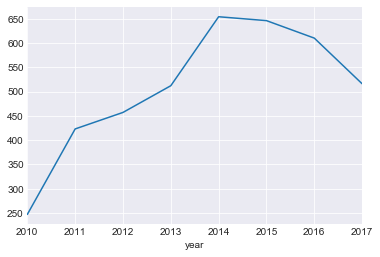

In [49]:
shares.groupby('year').size().plot()

## Descriptive Stats

In [11]:
# Notnull values
shares.describe()

,pkp_shares,doi_shares,pmc_shares,pmid_shares,fb_shares,am_shares,year,diff
count,26558.00,18766.00,3647.00,391.00,44094.00,14586.00,207941.00,9876.00
mean,1.08,0.97,0.76,2.75,1.15,0.82,2014.16,2.16
std,13.26,6.76,8.63,25.04,13.45,3.21,2.21,24.77
min,0.00,0.00,0.00,0.00,0.00,0.00,2010.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2012.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,0.00
75%,1.00,1.00,0.00,1.00,1.00,1.00,2016.00,1.00
max,1847.00,321.00,303.00,396.00,2081.00,276.00,2017.00,1805.00


In [114]:
# Compare those articles that were found on Altmetric
shares[shares.am_shares.notnull()].describe()

,pkp_shares,doi_shares,pmc_shares,pmid_shares,fb_shares,am_shares,year,diff
count,6980.00,3072.00,2833.00,309.00,9876.00,14586.00,14586.00,9876.00
mean,3.03,2.24,0.94,3.37,3.20,0.82,2014.33,2.16
std,25.58,13.78,9.78,28.15,27.72,3.21,1.95,24.77
min,0.00,0.00,0.00,0.00,0.00,0.00,2010.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00
50%,1.00,1.00,0.00,0.00,1.00,0.00,2015.00,0.00
75%,2.00,2.00,0.00,1.00,2.00,1.00,2016.00,1.00
max,1847.00,321.00,303.00,396.00,2081.00,276.00,2017.00,1805.00


In [130]:
shares[['am_shares', 'fb_shares']].dropna().describe()

,am_shares,fb_shares
count,9876.00,9876.00
mean,1.04,3.20
std,3.77,27.72
min,0.00,0.00
25%,0.00,0.00
50%,1.00,1.00
75%,1.00,2.00
max,276.00,2081.00


## Plots

In [148]:
shares = shares[shares.doi_prefix.isin(p_2012)]

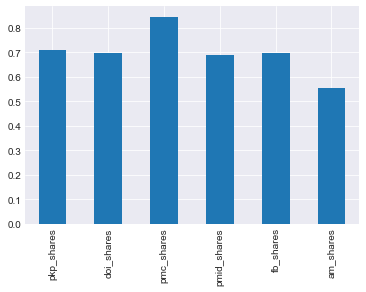

In [14]:
# Ratio of results with 0 shares
_ = shares[[x for x in shares.columns if "_shares" in x]]
_ = _.apply(lambda x: x==0).sum().div(shares.count())
_[[x for x in shares.columns if "_shares" in x]].plot(kind="bar")

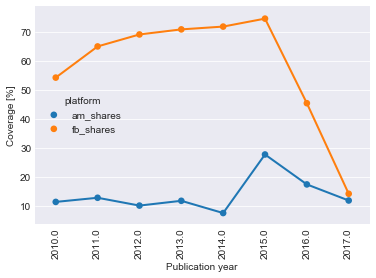

In [50]:
# Coverage
platforms = ['am_shares', 'fb_shares']
_ = shares.groupby('year')[platforms].apply(lambda x: x.notnull().mean()*100).reset_index()
_ = _.melt(id_vars = ['year'], var_name="platform", value_name="coverage")

sns.pointplot(x="year", y="coverage", hue="platform", data=_,
             scale=0.75)
plt.xticks(rotation=90);
plt.ylabel("Coverage [%]");
plt.xlabel("Publication year");

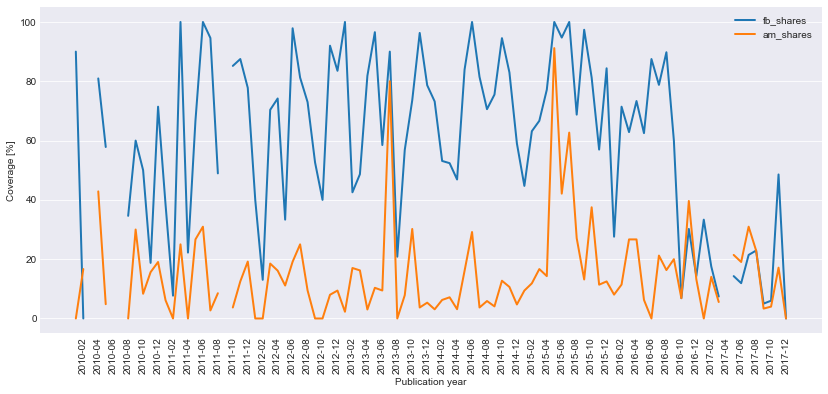

In [51]:
# Coverage
platforms = ['fb_shares', 'am_shares']

_ = shares
_ = _.set_index('date').groupby(pd.TimeGrouper('M'))[platforms].apply(lambda x: x.notnull().mean()*100).reset_index()
_ = _.melt(id_vars = ['date'], var_name="platform", value_name="coverage")
_['date'] = _['date'].dt.strftime('%Y-%m')

plt.figure(figsize=(14,6))
for line in _.platform.unique().tolist():
    __ = _[_.platform == line].sort_values('date')
    plt.plot(__['date'], __['coverage'], lw=2, marker="")

plt.legend(platforms)
plt.xticks(rotation=90);
plt.ylabel("Coverage [%]");
plt.xlabel("Publication year");
plt.setp(plt.gca().get_xticklabels()[::2], visible=False);
plt.gca().xaxis.grid(False)

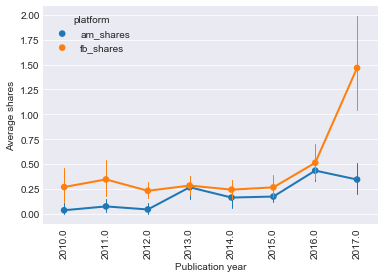

In [52]:
_ = shares[['year', 'am_shares', 'fb_shares']]
_ = _.melt(id_vars = ['year'], var_name="platform", value_name="shares")
sns.pointplot(x="year", y="shares", hue="platform",
              data=_, scale=.75, errwidth=1);
plt.xticks(rotation=90);
plt.ylabel("Average shares");
plt.xlabel("Publication year");

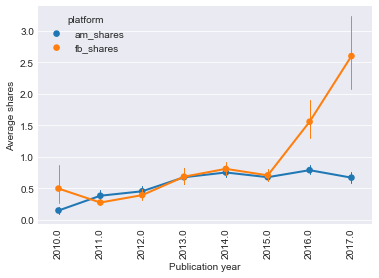

In [36]:
_ = shares[['year', 'am_shares', 'fb_shares']]
_ = _.melt(id_vars = ['year'], var_name="platform", value_name="shares")
sns.pointplot(x="year", y="shares", hue="platform",
              data=_, scale=.75, errwidth=1);
plt.xticks(rotation=90);
plt.ylabel("Average shares");
plt.xlabel("Publication year");

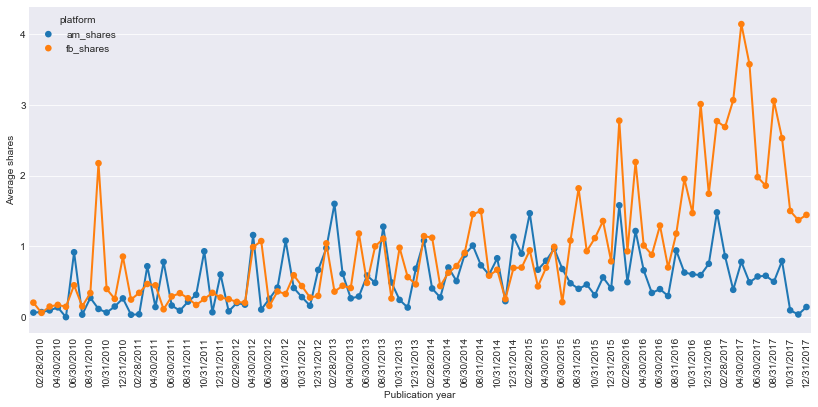

In [37]:
_ = shares[['date', 'am_shares', 'fb_shares']]
_ = _.set_index('date').groupby(pd.TimeGrouper('M')).mean()
_ = _.reset_index().melt(id_vars = ['date'], var_name="platform", value_name="shares")
_['date'] = _['date'].dt.strftime('%m/%d/%Y')

plt.figure(figsize=(14,6))
sns.pointplot(x="date", y="shares", hue="platform",
              data=_, scale=.75);
plt.xticks(rotation=90);
plt.setp(plt.gca().get_xticklabels()[::2], visible=False)
plt.ylabel("Average shares");
plt.xlabel("Publication year");

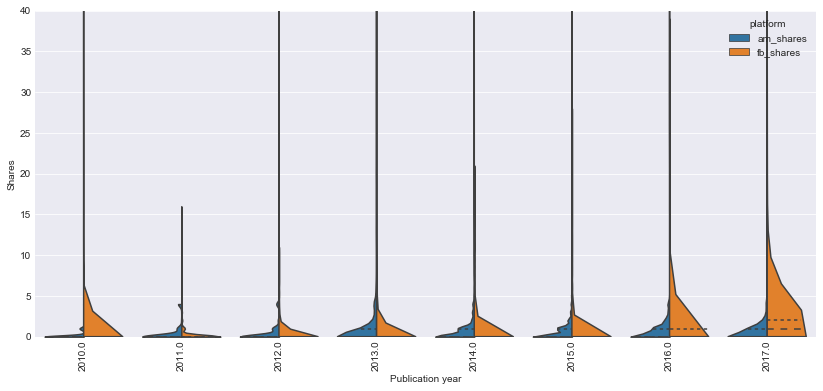

In [41]:
_ = shares[['year', 'am_shares', 'fb_shares']]
_ = _.melt(id_vars = ['year'], var_name="platform", value_name="shares")

plt.figure(figsize=(14,6))
sns.violinplot(x="year", y="shares", hue="platform", scale="width", 
              data=_, split=True, scale_hue=True, inner="quartile", cut=0);
plt.xticks(rotation=90);
plt.ylabel("Shares");
plt.xlabel("Publication year");
plt.ylim(0, 40);

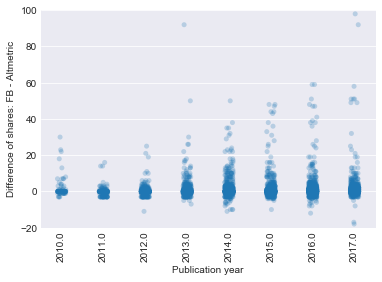

In [42]:
sns.stripplot(x="year", y="diff", data=shares, jitter=True, dodge=True, alpha=.25, color=sns.color_palette()[0]);
plt.xticks(rotation=90);
plt.ylim(-20,100)
plt.ylabel('Difference of shares: FB - Altmetric');
plt.xlabel("Publication year");

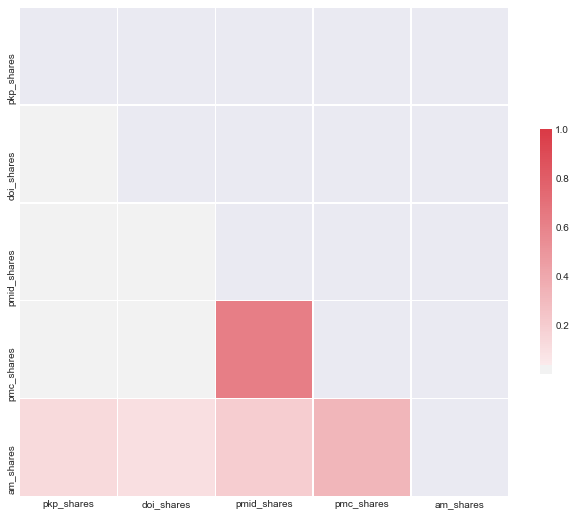

In [44]:
corr = shares.fillna(0)[['pkp_shares', 'doi_shares', 'pmid_shares', 'pmc_shares', 'am_shares']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})